In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import pandas as pd

import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D, BatchNormalization,Flatten,Dense,ReLU,LeakyReLU, Reshape, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

import tensorflow as tf
tf.enable_eager_execution()
print(tf.executing_eagerly())


Using TensorFlow backend.


True


In [2]:
class DataUtil:
    """
    Creates data with [img,bboxes,shape_types] as a single datapoint.
    """
    def __init__(self,img_shape,num_shapes):
        """
        :@param img_shape: Shape of image to be generated.
        :@param num_shapes: Number of shapes present in an image.
        """
        self.img_shape = img_shape
        self.num_shapes = num_shapes
        
    def get_data_points(self,num_examples):
        imgs = []
        boxes = []
        shape_classes = []
        for i in range(num_examples):
            img,bboxes,shape_types = self.get_annotated_image()
            imgs.append(img)
            boxes.append(bboxes)
            shape_classes.append(shape_types)
        imgs = np.array(imgs)
        boxes = np.array(boxes)
        shape_classes = np.array(shape_classes)
        return imgs,boxes,shape_classes
    
    def get_annotated_image(self):
        img_shape = self.img_shape
        num_shapes = self.num_shapes
        img = np.zeros(shape=img_shape)
        # Add random objects to image.
        shape_types = np.random.randint(0,2,size=num_shapes)
        bboxes = []
        for shape_type in shape_types:
            if shape_type == 0:
                # type 0 is rectangle.
                p1,p2,color,thickness,bbox = self.__get_rectangle(img_shape)
                cv2.rectangle(img,p1,p2,color,thickness)
                bboxes.append(bbox)
            elif shape_type == 1:
                # type 1 is circle.
                center,radius,color,thickness,bbox = self.__get_circle(img_shape)
                cv2.circle(img,center,radius,color,thickness)
                bboxes.append(bbox)
        return img,bboxes,shape_types
    
    def __get_rectangle(self,img_shape):
        def get_points():
            x1 = np.random.randint(0,img_shape[1])
            y1 = np.random.randint(0,img_shape[0])
            diff = 30
            x2 = np.random.randint(np.max([x1-diff,0]),np.min([x1+diff,img_shape[1]]))
            y2 = np.random.randint(np.max([y1-diff,0]),np.min([y1+diff,img_shape[1]]))
            p1 = (x1,y1)
            p2 = (x2,y2)
            color = tuple([int(x) for x in np.random.randint(0,255,size=(3,))])
            thickness = np.random.randint(1,2)
            bbox = (np.min([x1,x2]), np.min([y1,y2]), np.max([x1,x2]), np.max([y1,y2]))
            return p1,p2,color,thickness,bbox
        p1,p2,color,thickness,bbox = get_points()
        while True:
            if abs(p1[0]-p2[0])>1 and abs(p1[1]-p2[1])>1:
                break
            p1,p2,color,thickness,bbox = get_points()
        return p1,p2,color,thickness,bbox
    
    def __get_circle(self,img_shape):
        # Select random center.
        while True:
            x = np.random.randint(0,img_shape[1])
            y = np.random.randint(0,img_shape[0])
            # Select radius
            diff = 20
            max_radius = np.min([abs(x-img_shape[1]), x , abs(y-img_shape[0]), y])
            if max_radius > 2:
                break
        radius = np.random.randint(2,max_radius)
        #radius = np.random.randint(np.max([np.min([x-diff,img_shape[1]]),np.min([y-diff,img_shape[0]])]), np.min([np.max([x+diff,img_shape[1]]),np.max([y+diff,img_shape[0]])]))
        color = tuple([int(x) for x in np.random.randint(0,255,size=(3,))])
        thickness = np.random.randint(1,2)
        x1 = x-radius
        y1 = y-radius
        x2 = x+radius
        y2 = y+radius
        center = (x,y)
        bbox = (x1,y1,x2,y2)
        return center,radius,color,thickness,bbox
        

In [3]:
class PlotUtil:
    def __init__(self,):
        self.font_rect_text = {'family': 'serif',
                                'color':  'red',
                                'weight': 'normal',
                                'size': 10,
                                }
    
    def plot_img_boxes(self,imgs,boxes,shape_classes,confidence_scores=None, n_cols=5,cell_width=1, cell_height=1):
        n_rows = int(len(imgs)/float(n_cols))
        n_rows = 1 if n_rows < 1 else n_rows
        fig_w = cell_width * n_cols
        fig_h = cell_height * n_rows
        print(n_rows,n_cols)
        plt.figure(figsize=(fig_w,fig_h))
        #ax = plt.axes()
        for i,img in enumerate(imgs):            
            plt.subplot(n_rows,n_cols,i+1)
            
            plt.imshow(img)
            # Add all boxes.
            for j,bbox in enumerate(boxes[i]):
                shape_class = shape_classes[i][j]
                color = "r" if shape_class == 1 else "g"
                text = "Circle" if shape_class == 1 else "Rect"
                if confidence_scores is not None:
                    text = text + ": {0:.2f}".format(confidence_scores[i][j])
                x,y = bbox[0],bbox[1]
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                rect = matplotlib.patches.Rectangle(xy=(x,y), width=w, height=h,ec="r", fc='none')
                cx = x + w
                cy = y + h
                #ax.add_artist(text)
                #ax.annotate(rect, (cx, cy), color='r', weight='bold',fontsize=6, ha='center', va='center')
                plt.gca().add_patch(rect)
                plt.text(x,y-1,text,fontdict=self.font_rect_text)
        plt.show()

In [4]:
class YoloUtil:    
    """
    Grid cell format is [(Obj_exists,x,y,w,h) * n_bboxes,[probability of each class]. So each cell is allowed to
    predict 'n_bboxes' number of bounding boxes. But only one box per cell is considered and that considered box 
    belongs to class that has highest class probability.
    """
    
    def __init__(self,img_shape,grid_shape,n_bboxes,n_classes):
        self.img_shape = img_shape
        self.grid_shape = grid_shape
        # Number of bounding boxes predicted per cell.
        self.n_bboxes = n_bboxes
        self.n_classes = n_classes
        self.cell_width = img_shape[1]/grid_shape[1]
        self.cell_height = img_shape[0]/grid_shape[0]
    
    
    def convert_to_yolo_grid(self,bboxes_lst,box_classes):
        grid = self.init_grid()
        for i in range(len(bboxes_lst)):
            bbox = bboxes_lst[i]
            box_class = box_classes[i]
            # Convert to yolo box.
            yolo_bbox = self.to_yolo_bbox(bbox)
            # Find grid cell row and col for box center.
            grid_row,grid_col = self.grid_cell_for_box(yolo_bbox)
            # Normalize yolo box.
            yolo_bbox = self.normalize_yolo_box(yolo_bbox)
            # Now create a 2D array with cols=5 where col_0 is confidence of object present or not
            # and col_1:col_4 are x_c,y_c,w,h. Number of rows will be equal to number of anchor boxes
            # with first row for rectangle and second row for circle.
            # Create one hot encoded class vector.
            bbox_vectors = np.zeros(shape=(self.n_bboxes,5)) # 5 for [confidence,x_c,y_c,w,h]
            bbox_vectors[box_class,0]=1.0
            bbox_vectors[box_class,1:]= yolo_bbox
            bbox_vectors_flattened = bbox_vectors.reshape(np.product(bbox_vectors.shape))
            class_vector = np.zeros(shape=(self.n_classes,))
            class_vector[box_class] = 1.0
            #Create final cell vector with [Obj_exists,x_c,y_c,w_box,h_box,P(class1),P(class2)]
            cell_vector = np.concatenate([bbox_vectors_flattened,class_vector])
            grid[grid_row,grid_col] = cell_vector
        return grid
            
        
    def normalize_yolo_box(self,yolo_bbox):     
        """
        @param: yolo_bbox --> Bounding box with format [Center x, Center y, box width, box height]
        Return: Normalized values of [Center x, Center y, box width, box height]
        """
        # Find row and col of grid in which center of box lies.
        grid_row,grid_col = self.grid_cell_for_box(yolo_bbox)
        #Find coorners of top left coordinates of grid cell.
        x_c,y_c,w_box,h_box = yolo_bbox
        c_x = grid_col * self.cell_width
        c_y = grid_row * self.cell_height
        # Normalize center coordinates w.r.t cell height and width.
        x_c = (x_c - c_x) / self.cell_width
        y_c = (y_c - c_y) / self.cell_height
        # Normalize height and width of bounding box w.r.t height and width of image.
        w_box = w_box / self.img_shape[1]
        h_box = h_box / self.img_shape[0]
        # Return normalized dims.
        return x_c,y_c,w_box,h_box
        
    def grid_cell_for_box(self,yolo_bbox):
        """
        Find grid row and col for given yolo_bbox
        @param: yolo_bbox --> Bounding box with format [Center x, Center y, box width, box height]
        """
        x_c,y_c,w_box,h_box = yolo_bbox
        row = int(y_c/self.cell_height)
        col = int(x_c/self.cell_width)
        return row,col
        
    def to_yolo_bbox(self,bbox):
        """
        Convert normal bounding box to yolo format bbox.
        @param: bbox --> Actual De-normalized bounding box with shape [x1,y1,x2,y2]
        Returns: [Center x, Center y, box width, box height]
        """
        # Find height,width,center coordinates of box.
        x1,y1,x2,y2 = bbox
        w_box = x2-x1
        h_box = y2-y1
        x_c = x1 + (w_box/2)
        y_c = y1 + (h_box/2)
        return (x_c,y_c,w_box,h_box)
        
        
        
    def init_grid(self):
        """
        Initializes blank grid of shape [grid_rows, grid_cols, [(Obj_exists,x,y,w,h) * n_bboxes,[probability of each class]]]
        """
        img_height,img_width = self.img_shape[:2]
        grid_row_count,grid_col_count = self.grid_shape[:2]
        # Structure of a cell vector [Obj_exists,x,y,w,h,[probability of each class]]
        grid = np.zeros(shape=(grid_row_count,grid_col_count, 5*self.n_bboxes+self.n_classes))
        return grid
        
    ##################### Yolo to normal #########################
    
    def convert_to_normal(self,grid,box_threshold=0.6):
        """
        Extract each cell of grid and if a bounding box is present then conver to normal [x1,y1,x2,y2]
        @param: box_threshold --> Any cell having its value at index 0 more than this value will be considered to have a valid box.
        
        Returns: A list of bounding boxes found in the grid.
        """
        bboxes = []
        for grid_row in range(grid.shape[0]):
            for grid_col in range(grid.shape[1]):
                cell = grid[grid_row,grid_col]
                # Remove section for class probabilities.
                cell = cell[:-self.n_classes]
                # Convert cell to 2D vector.
                cell = cell.reshape(self.n_bboxes,5)
                # Now for each bbox check if it has valid confidence if so convert it to normal box.
                for i in range(cell.shape[0]):
                    box_vector = cell[i]
                    # Check if cell does not have a box then continue.
                    if box_vector[0] < box_threshold:
                        continue
                    # Actual bounding box resides in dims 1,2,3,4 of box.
                    box = box_vector[1:5]
                    # De-normalize yolo box.
                    de_norm_yolo_box = self.de_normalize_yolo_box(box,grid_row,grid_col)
                    # Convert de-normalized yolo box to normal box format.
                    normal_box = self.to_normal_box(de_norm_yolo_box)
                    bboxes.append(normal_box)
        return bboxes
    
    def to_normal_box(self,de_norm_yolo_box):
        """
        Converts given de-normalized yolo box to normal bounding box with x1,y1,x2,y2
        """
        x_c,y_c,w,h = de_norm_yolo_box
        x1 = x_c - (w/2.0)
        y1 = y_c - (h/2.0)
        x2 = x_c + (w/2.0)
        y2 = y_c + (h/2.0)
        return x1,y1,x2,y2
    
    def de_normalize_yolo_box(self,yolo_bbox,grid_row,grid_col):
        """
        @param: yolo_bbox --> [Center x, Center y, box width, box height]
        Returns: Normal bounding box in De-normalized state.
        """
        # Find cell top left coordinates.
        c_x = grid_col * self.cell_width
        c_y = grid_row * self.cell_height
        # Normalize center w.r.t cell dims and add top left coordinates.
        x_c,y_c,w_box,h_box = yolo_bbox
        x_c = (x_c * self.cell_width) + c_x
        y_c = (y_c * self.cell_height) + c_y
        # De-normalize height and width by multiplying it with image dims.
        w_box = w_box * self.img_shape[1]
        h_box = h_box * self.img_shape[0]
        return x_c,y_c,w_box,h_box
        
    

In [5]:
class FormatConversion:
    def __init__(self,img_shape,grid_shape,n_classes,n_anchors):
        self.img_shape = img_shape
        self.grid_shape = grid_shape
        self.cell_width = self.img_shape[1]/self.grid_shape[1]
        self.cell_height = self.img_shape[0]/self.grid_shape[0]
        self.n_classes = n_classes
        self.n_anchors = n_anchors
        self.box_length = 5 + self.n_classes
        
    def norm_actual_boxes(self,boxes):
        result = []
        for box in boxes:
            x1,y1,x2,y2 = box
            x1 = x1/self.img_shape[1]
            y1 = y1/self.img_shape[0]
            x2 = x2/self.img_shape[1]
            y2 = y2/self.img_shape[0]
            result.append([x1,y1,x2,y2])
        result = np.array(result)
        return result
    
    def de_norm_actual_boxes(self,boxes):
        result = []
        for box in boxes:
            x1,y1,x2,y2 = box
            x1 = x1 * self.img_shape[1]
            y1 = y1 * self.img_shape[0]
            x2 = x2 * self.img_shape[1]
            y2 = y2 * self.img_shape[0]
            result.append([x1,y1,x2,y2])
        result = np.array(result)
        return result
    
    def convert_to_norm_yolo_grid(self,boxes,shape_classes):
        """
        Converts un-normalized 'boxes' to normalized yolo grid. Works for a single grid and not a batch of grids.
        """
        grid = np.zeros(shape=(self.grid_shape[0], self.grid_shape[1], self.box_length))
        for i,box in enumerate(boxes):
            x1,y1,x2,y2 = boxes[i]
            # Find grid cell in which center of box lies.
            row,col = self.__grid_cell_for_box(box)
            # Find yolo coordinates.
            x,y,w,h = x1+(x2-x1)/2.0, y1+(y2-y1)/2.0, x2-x1, y2-y1
            #print("x,y,w,h,row,col",x,y,w,h,row,col)
            # Find top left offset coords of grid cell.
            cell_x, cell_y = col * self.cell_width, row * self.cell_height
            # Find x,y w.r.t cell top coords and normalize w,h w.r.t image w,h.
            x = (x - cell_x)/self.cell_width
            y = (y - cell_y)/self.cell_height
            w = w/self.img_shape[1]
            h = h/self.img_shape[0]
            # Create class vector.
            class_vect = [0.0] * self.n_classes
            class_vect[shape_classes[i]] = 1.0
            box_vect = [1.0,x,y,w,h] + class_vect           
            grid[row,col] = box_vect
        # Repeat the grid for number of anchors.
        grid = np.concatenate([grid] * self.n_anchors,axis=2)
        # Reshape grid such that boxes in last dim are in separate rows.
        grid = grid.reshape(grid.shape[0],grid.shape[1],self.n_anchors,self.box_length)
        return grid
    
    def convert_yolo_grid_to_boxes(self,yolo_grid):
        """
        :@param yolo_grid: Single yolo grid.
        :returns: confidence_scores, boxes, class_probs
        """
        grid = yolo_grid.copy()
        cell_x = np.tile(np.array(range(self.grid_shape[1])),self.grid_shape[0]).reshape(self.grid_shape[0],self.grid_shape[1])
        cell_x = cell_x * self.cell_width
        cell_y = np.tile(np.array(range(self.grid_shape[0])), self.grid_shape[1]).reshape(self.grid_shape[0], self.grid_shape[1]).T
        cell_y = cell_y * self.cell_height        
        # De-norm x,y for each anchor box.
        for i in range(self.n_anchors):
            grid[:,:,i,1] = (grid[:,:,i,1] * self.cell_width) + cell_x
            grid[:,:,i,2] = (grid[:,:,i,2] * self.cell_height) + cell_y
            grid[:,:,i,3] *= self.img_shape[1]
            grid[:,:,i,4] *= self.img_shape[0]        
        # Remove grid structure. Make each box a single row.
        grid = grid.reshape(np.product(grid.shape[:-1]), grid.shape[-1])        
        # Collect values.
        confidence_scores = grid[:,0]
        boxes = np.array([self.__convert_yolo_to_denorm_box(grid[i,1:5]) for i in range(grid.shape[0])])
        class_probs = grid[:,-self.n_classes:]
        return confidence_scores, boxes, class_probs
        
    def __convert_yolo_to_denorm_box(self,yolo_box):
        x,y,w,h = yolo_box
        x1 = x - (w/2.0)
        y1 = y - (h/2.0)
        x2 = x + (w/2.0)
        y2 = y + (h/2.0)
        actual_box = np.array([x1,y1,x2,y2])
        return actual_box
        
        
    def __grid_cell_for_box(self,box):
        x1,y1,x2,y2 = box
        x_c, y_c = x1+((x2-x1)/2.0), y1+((y2-y1)/2.0)        
        row = int(y_c/self.cell_height)
        col = int(x_c/self.cell_width)
        return row,col
 
        

In [6]:
# Initialize params.

img_shape = (50,50,3)
n_anchors = 2
n_classes = 2
n_shapes_per_img = 2
box_length = 5 + n_classes
grid_shape = (4,4,(5+n_classes) * n_anchors)
cell_width = img_shape[1] / grid_shape[1]
cell_height = img_shape[0] / grid_shape[0]

In [7]:
data_util = DataUtil(img_shape = img_shape, num_shapes = n_shapes_per_img)
plot_util = PlotUtil()
format_conversion = FormatConversion(img_shape,grid_shape,n_classes,n_anchors)


imgs (10000, 50, 50, 3)
grids (10000, 4, 4, 2, 7)
2 5


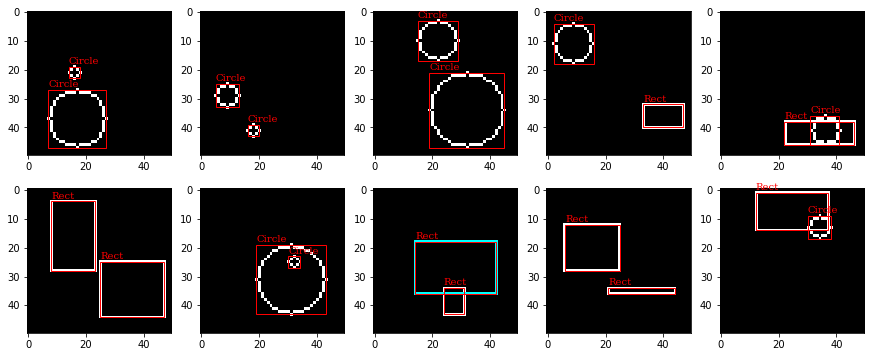

In [8]:
num_examples=10000

imgs,boxes,shape_classes = data_util.get_data_points(num_examples=num_examples)
grids = [format_conversion.convert_to_norm_yolo_grid(boxes[i],shape_classes[i]) for i in range(len(imgs))]
grids = np.array(grids)
print("imgs",imgs.shape)
print("grids",grids.shape)

num_plot=10
idx = np.random.permutation(np.arange(len(imgs)))[:num_plot]
plot_util.plot_img_boxes(imgs[idx],boxes[idx],shape_classes[idx],cell_width=3,cell_height=3)


In [9]:


grid = format_conversion.convert_to_norm_yolo_grid(boxes[0],shape_classes[0])
gen_conf,gen_boxes,gen_classes = format_conversion.convert_yolo_grid_to_boxes(grid)
print("Actual box.")
print(boxes[0])
print("Generated box.")
print(gen_boxes[gen_conf==1])

Actual box.
[[20  2 26  8]
 [ 1 34  3 37]]
Generated box.
[[20.  2. 26.  8.]
 [20.  2. 26.  8.]
 [ 1. 34.  3. 37.]
 [ 1. 34.  3. 37.]]


In [10]:

def IOU(boxes,boxes_pred):
    x1 = tf.maximum(boxes[:,:,:,:,0], boxes_pred[:,:,:,:,0])
    y1 = tf.maximum(boxes[:,:,:,:,1], boxes_pred[:,:,:,:,1])
    x2 = tf.minimum(boxes[:,:,:,:,2], boxes_pred[:,:,:,:,2])
    y2 = tf.minimum(boxes[:,:,:,:,3], boxes_pred[:,:,:,:,3])
    
    areas_boxes = tf.multiply(boxes[:,:,:,:,2] - boxes[:,:,:,:,0] + 1., boxes[:,:,:,:,3] - boxes[:,:,:,:,1] + 1.)
    areas_boxes_pred = tf.multiply(boxes_pred[:,:,:,:,2] - boxes_pred[:,:,:,:,0] + 1., boxes_pred[:,:,:,:,3] - boxes_pred[:,:,:,:,1] + 1.)
    intersection_area = tf.multiply(tf.maximum(0., x2 - x1 + 1.) , tf.maximum(0., y2 - y1 + 1.))
    iou = intersection_area / (areas_boxes + areas_boxes_pred - intersection_area)
    return iou

def get_actual_boxes(Y,cell_x,cell_y):
    # De-norm x.
    x = Y[:,:,:,:,1] * cell_width + cell_x
    y = Y[:,:,:,:,2] * cell_height + cell_y
    w = Y[:,:,:,:,3] * img_shape[1]
    h = Y[:,:,:,:,4] * img_shape[0]
    x1 = (x - w)/2.0
    y1 = (y - h)/2.0
    x2 = (x + w)/2.0
    y2 = (y + h)/2.0
    return tf.concat([x1[...,None],y1[...,None],x2[...,None],y2[...,None]],axis=4)
    
def yolo_loss_single_box_per_cell(lambda_obj=5.0, lambda_no_obj=0.5):
    """
    This function considers a single predicted box for each grid cell. Predicted box having max IOU with actual box
    is considered and rest of predicted boxes are ignored.
    """
    def fn(Y,Y_pred):
        Y_shape = tf.shape(Y)
        cell_x = np.tile(np.array(range(grid_shape[1])),grid_shape[0]).reshape(grid_shape[0],grid_shape[1]) * cell_width
        cell_x = cell_x[None,:,:,None]
        cell_y = np.tile(np.array(range(grid_shape[0])),grid_shape[1]).reshape(grid_shape[1],grid_shape[0]).T * cell_height
        cell_y = cell_y[None,:,:,None]

        # Find x1,y1,x2,y2 i.e. actual de-normalized boxes.
        boxes = get_actual_boxes(Y,cell_x,cell_y)
        boxes_pred = get_actual_boxes(Y_pred,cell_x,cell_y)
        # Compute IOU for boxes.
        iou = IOU(boxes,boxes_pred)
        # For predicted boxes find which box (index among n_anchor indicies) has maximum IOU with actual box.
        max_iou_box_index = tf.argmax(iou,axis=3,output_type=tf.int32)
        # Now for each cell select box having maximum IOU index.
        dim1,dim2,dim3 = tf.meshgrid(tf.range(0,Y_shape[0]), tf.range(0,grid_shape[0]), tf.range(0,grid_shape[1]),indexing="ij")
        indicies = tf.stack([dim1,dim2,dim3,max_iou_box_index],axis=-1)

        # In prediction keep only those boxes that have highest IOU with actual box.
        Y_pred = tf.gather_nd(Y_pred, indicies)
        # In actual also keep only single box in each cell. Take first box.
        Y = Y[:,:,:,0,:]

        # Compute mask and inv_mask.
        mask = Y[:,:,:,0,None]
        inv_mask = K.map_fn(lambda x: K.switch(K.equal(x,0.),x+1.,x-1.),mask)
        
        # Compute x,y loss.
        #xy_loss = tf.reduce_sum(mask * ((Y[:,:,:,1] - Y_pred[:,:,:,1])**2 + (Y[:,:,:,2] - Y_pred[:,:,:,2])**2))
        x = Y[:,:,:,1,None] + cell_x #x = Y[:,:,:,:,1] * cell_width + cell_x
        y = Y[:,:,:,2,None] + cell_y#y = Y[:,:,:,:,2] * cell_height + cell_y
        x_pred = Y_pred[:,:,:,1,None] + cell_x
        y_pred = Y_pred[:,:,:,2,None] + cell_y
        xy_loss = tf.reduce_sum(mask * ((x-x_pred)**2 + (y-y_pred)**2))
        # Compute w,h loss.
        #wh_loss = tf.reduce_sum(mask * ((tf.sqrt(Y[:,:,:,3]) - tf.sqrt(Y_pred[:,:,:,3]))**2 + (tf.sqrt(Y[:,:,:,4]) - tf.sqrt(Y_pred[:,:,:,4]))**2))
        w = Y[:,:,:,3,None] #* img_shape[1]
        h = Y[:,:,:,4,None] #* img_shape[0]
        w_pred = Y_pred[:,:,:,3,None] #* img_shape[1]
        h_pred = Y_pred[:,:,:,4,None] #* img_shape[0]
        wh_loss = tf.reduce_sum(mask * ((tf.sqrt(w) - tf.sqrt(w_pred))**2 + (tf.sqrt(h) - tf.sqrt(h_pred))**2))
        
        # Object confidence loss.
        obj_conf_loss = tf.reduce_sum(mask * (Y[:,:,:,0,None] - Y_pred[:,:,:,0,None])**2)
        #obj_conf_loss = tf.reduce_sum(mask * -1.0 * (Y[:,:,:,0,None]*tf.log(Y_pred[:,:,:,0,None]) + (1.0 - Y[:,:,:,0,None])*tf.log(1.0 - Y_pred[:,:,:,0,None])))
        
        # No Object confidence loss.
        no_obj_conf_loss = tf.reduce_sum(inv_mask * (Y[:,:,:,0,None] - Y_pred[:,:,:,0,None])**2)
        #no_obj_conf_loss = tf.reduce_sum(inv_mask * -1.0 * (Y[:,:,:,0,None]*tf.log(Y_pred[:,:,:,0,None]) + (1.0 - Y[:,:,:,0,None])*tf.log(1.0 - Y_pred[:,:,:,0,None])))
        
        # Class loss.
        #class_loss = tf.reduce_sum(mask[...,None] * (Y[:,:,:,-n_classes:] - Y[:,:,:,-n_classes:])**2)
        class_loss = tf.reduce_sum(mask * tf.reduce_sum((Y[:,:,:,-n_classes:] - Y_pred[:,:,:,-n_classes:])**2, axis=3)[:,:,:,None])
        
        # Total loss.
        loss = lambda_obj * (xy_loss + wh_loss) + obj_conf_loss + (lambda_no_obj * no_obj_conf_loss) + class_loss        
        avg_loss = tf.cast(loss, tf.float64) / tf.cast(tf.shape(Y)[0],tf.float64)
        print("xy_loss",xy_loss)
        print("wh_loss",wh_loss)
        print("obj_conf_loss",obj_conf_loss)
        print("no_obj_conf_loss",no_obj_conf_loss)
        print("class_loss",class_loss)
        print("loss", loss)
        print("avg_loss", avg_loss)
        return avg_loss
        #return tf.Variable(1.)
    return fn


def yolo_loss_multiple_box_per_cell(lambda_obj=5.0, lambda_no_obj=0.5):
    """
    This function considers all the predicted boxes per cell for loss computation.
    """
    def fn(Y,Y_pred):
        Y_shape = tf.shape(Y)
        cell_x = np.tile(np.array(range(grid_shape[1])),grid_shape[0]).reshape(grid_shape[0],grid_shape[1]) * cell_width
        cell_x = cell_x[None,:,:,None]
        cell_y = np.tile(np.array(range(grid_shape[0])),grid_shape[1]).reshape(grid_shape[1],grid_shape[0]).T * cell_height
        cell_y = cell_y[None,:,:,None]

        # Find x1,y1,x2,y2 i.e. actual de-normalized boxes.
        boxes = get_actual_boxes(Y,cell_x,cell_y)
        boxes_pred = get_actual_boxes(Y_pred,cell_x,cell_y)
        # Compute IOU for boxes.
        iou = IOU(boxes,boxes_pred)
        
        # Compute mask and inv_mask.
        mask = Y[:,:,:,:,0]
        #mask = mask[:,:,:,None]
        inv_mask = K.map_fn(lambda x: K.switch(K.equal(x,0.),x+1.,x-1.),mask)
        
        # Compute x,y loss.
        x = Y[:,:,:,:,1] + cell_x #x = Y[:,:,:,:,1] * cell_width + cell_x
        y = Y[:,:,:,:,2] + cell_y#y = Y[:,:,:,:,2] * cell_height + cell_y
        x_pred = Y_pred[:,:,:,:,1] + cell_x
        y_pred = Y_pred[:,:,:,:,2] + cell_y
        xy_loss = tf.reduce_sum(mask * ((x-x_pred)**2 + (y-y_pred)**2))
        #xy_loss = tf.reduce_sum(mask * ((Y[:,:,:,:,1] - Y_pred[:,:,:,:,1])**2 + (Y[:,:,:,:,2] - Y_pred[:,:,:,:,2])**2))
        # Compute w,h loss.
        w = Y[:,:,:,:,3] * img_shape[1]
        h = Y[:,:,:,:,4] * img_shape[0]
        w_pred = Y_pred[:,:,:,:,3] * img_shape[1]
        h_pred = Y_pred[:,:,:,:,4] * img_shape[0]
        wh_loss = tf.reduce_sum(mask * ((tf.sqrt(w) - tf.sqrt(w_pred))**2 + (tf.sqrt(h) - tf.sqrt(h_pred))**2))
        #wh_loss = tf.reduce_sum(mask * ((tf.sqrt(Y[:,:,:,:,3]) - tf.sqrt(Y_pred[:,:,:,:,3]))**2 + (tf.sqrt(Y[:,:,:,:,4]) - tf.sqrt(Y_pred[:,:,:,:,4]))**2))
        
        # Confidence loss.
        #obj_conf_loss = tf.reduce_sum(mask * ((Y[:,:,:,:,0]*iou - Y_pred[:,:,:,:,0])**2 * Y[:,:,:,:,0]))
        #noobj_conf_loss = tf.reduce_sum(inv_mask * ((Y[:,:,:,:,0]*iou - Y_pred[:,:,:,:,0])**2 * Y[:,:,:,:,0]))
        obj_conf_loss = tf.reduce_sum(mask * ((Y[:,:,:,:,0] - Y_pred[:,:,:,:,0]*iou)**2))
        no_obj_conf_loss = tf.reduce_sum(inv_mask * ((Y[:,:,:,:,0] - Y_pred[:,:,:,:,0]*iou)**2))
        
        # Class loss.
        class_loss = tf.reduce_sum(mask * tf.reduce_sum((Y[:,:,:,:,-n_classes:] - Y_pred[:,:,:,:,-n_classes:])**2, axis=4))
                
        # Total loss.
        loss = lambda_obj * (xy_loss + wh_loss) + obj_conf_loss + lambda_no_obj * no_obj_conf_loss + class_loss
        avg_loss = tf.cast(loss, tf.float64) / tf.cast(tf.shape(Y)[0],tf.float64)
        print("xy_loss",xy_loss)
        print("wh_loss",wh_loss)
        print("obj_conf_loss",obj_conf_loss)
        print("no_obj_conf_loss",no_obj_conf_loss)
        print("class_loss",class_loss)
        print("loss", loss)
        print("avg_loss", avg_loss)
        return avg_loss
        #return tf.Variable(1.)
    return fn

#yolo_loss(np.array([grid]*2),np.array([grid]*2))    
#yolo_loss_multiple_box_per_cell()(np.array([grid]*2),np.array([np.random.uniform(0,1,size=grid.shape)]*2))   
yolo_loss_single_box_per_cell()(np.array([grid]*2),np.array([np.random.uniform(0,1,size=grid.shape)]*2))   


xy_loss tf.Tensor(0.8209527718899057, shape=(), dtype=float64)
wh_loss tf.Tensor(1.4382911915741914, shape=(), dtype=float64)
obj_conf_loss tf.Tensor(0.34167663035774587, shape=(), dtype=float64)
no_obj_conf_loss tf.Tensor(8.01165876366175, shape=(), dtype=float64)
class_loss tf.Tensor(2.66092128161995, shape=(), dtype=float64)
loss tf.Tensor(18.304647111129057, shape=(), dtype=float64)
avg_loss tf.Tensor(9.152323555564529, shape=(), dtype=float64)


<tf.Tensor: id=336, shape=(), dtype=float64, numpy=9.152323555564529>

In [11]:
X = imgs/255.0
Y = grids

In [17]:

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32,3,input_shape=img_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Conv2D(64,3,input_shape=img_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Conv2D(128,3,input_shape=img_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Conv2D(256,3,input_shape=img_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Conv2D(512,3,input_shape=img_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(rate=0.3))

#model.add(tf.keras.layers.Conv2D(512,3,input_shape=img_shape))
#model.add(tf.keras.layers.ReLU())
#model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Conv2D(1024,3,input_shape=img_shape))
model.add(tf.keras.layers.ReLU())

#model.add(tf.keras.layers.Conv2D(1024,3,input_shape=img_shape))
#model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(rate=0.3))

model.add(tf.keras.layers.Dense(np.product([grid_shape[0],grid_shape[1],n_anchors,box_length]),activation="sigmoid"))
model.add(tf.keras.layers.Reshape(target_shape=[grid_shape[0],grid_shape[1],n_anchors,box_length]))

opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss=yolo_loss_single_box_per_cell(lambda_obj=5.0, lambda_no_obj=0.8), optimizer=opt ,metrics=["accuracy"])
model.summary()




xy_loss Tensor("loss_1/reshape_1_loss/Sum:0", shape=(), dtype=float32)
wh_loss Tensor("loss_1/reshape_1_loss/Sum_1:0", shape=(), dtype=float32)
obj_conf_loss Tensor("loss_1/reshape_1_loss/Sum_2:0", shape=(), dtype=float32)
no_obj_conf_loss Tensor("loss_1/reshape_1_loss/Sum_3:0", shape=(), dtype=float32)
class_loss Tensor("loss_1/reshape_1_loss/Sum_5:0", shape=(), dtype=float32)
loss Tensor("loss_1/reshape_1_loss/add_24:0", shape=(), dtype=float32)
avg_loss Tensor("loss_1/reshape_1_loss/truediv_9:0", shape=(), dtype=float64)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 32)     

In [18]:
callback_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "loss", verbose=1)
hist = model.fit(X,Y,batch_size=16,epochs=150,validation_split=0.2, callbacks = [callback_lr_reduce])
# epochs 60 (moderate results)

# Use non-max supression.
# Train for 100 epochs.
# ---- (Works with 4x4 grid)Increase model capacity.
# For single box per cell loss, only one box could occur in a cell. Thus in a single cell only keep box with highest confidence.
# Try to increase xy loss value.
# ---- (Don't go beyond 1.0) Try to increase no obj loss.
# ---- (Didn't worked well) Increase grid size and image size.
# ---- (Didn't worked well) Use log loss for classes.

Train on 8000 samples, validate on 2000 samples
Epoch 1/150
8000/8000 [==============================] - 51s 6ms/sample - loss: 3.8579 - acc: 0.1153 - val_loss: 3.7026 - val_acc: 0.1250
Epoch 2/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 3.7145 - acc: 0.1248 - val_loss: 3.5674 - val_acc: 0.0971
Epoch 3/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 3.3929 - acc: 0.0918 - val_loss: 3.1681 - val_acc: 0.0783
Epoch 4/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 3.2773 - acc: 0.0456 - val_loss: 3.1105 - val_acc: 0.0316
Epoch 5/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 3.2345 - acc: 0.0346 - val_loss: 3.0482 - val_acc: 0.0361
Epoch 6/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 3.1055 - acc: 0.0337 - val_loss: 2.8993 - val_acc: 0.0280
Epoch 7/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 2.9389 - acc: 0.0269 - val_loss: 2.7973 - va

8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2819 - acc: 0.0083 - val_loss: 1.5234 - val_acc: 0.0068
Epoch 60/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2503 - acc: 0.0085 - val_loss: 1.5659 - val_acc: 0.0070
Epoch 61/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2460 - acc: 0.0084 - val_loss: 1.5239 - val_acc: 0.0067
Epoch 62/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2639 - acc: 0.0087 - val_loss: 1.5059 - val_acc: 0.0065
Epoch 63/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2404 - acc: 0.0083 - val_loss: 1.5038 - val_acc: 0.0067
Epoch 64/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2279 - acc: 0.0085 - val_loss: 1.4952 - val_acc: 0.0063
Epoch 65/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 1.2212 - acc: 0.0082 - val_loss: 1.5329 - val_acc: 0.0064
Epoch 66/150
8000/8000 [================

Epoch 118/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 0.9646 - acc: 0.0085 - val_loss: 1.5054 - val_acc: 0.0070
Epoch 119/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 0.9701 - acc: 0.0086 - val_loss: 1.5450 - val_acc: 0.0071
Epoch 120/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 0.9677 - acc: 0.0086 - val_loss: 1.5093 - val_acc: 0.0062
Epoch 121/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 0.9489 - acc: 0.0087 - val_loss: 1.5248 - val_acc: 0.0066
Epoch 122/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 0.9317 - acc: 0.0087 - val_loss: 1.5298 - val_acc: 0.0063
Epoch 123/150
8000/8000 [==============================] - 49s 6ms/sample - loss: 0.9544 - acc: 0.0085 - val_loss: 1.5216 - val_acc: 0.0063
Epoch 124/150
8000/8000 [==============================] - 50s 6ms/sample - loss: 0.9413 - acc: 0.0084 - val_loss: 1.5389 - val_acc: 0.0064
Epoch 125/150
8000/8

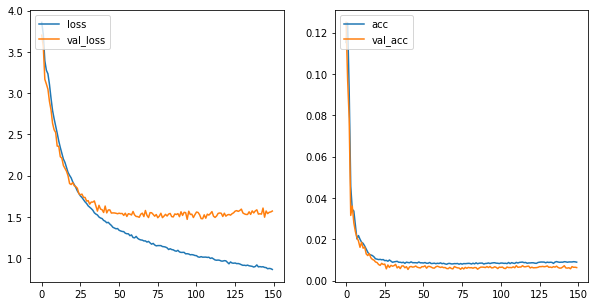

In [19]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend(loc="upper left")

plt.subplot(1,2,2)
plt.plot(hist.history["acc"],label="acc")
plt.plot(hist.history["val_acc"],label="val_acc")
plt.legend(loc="upper left")

plt.show()


In [20]:
def IOU_singlebox(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    #print(iou)
    # return the intersection over union value
    return iou

def non_max_supression(confidence_scores, boxes, class_probs, iou_threshold=0.4):
    # Keep confidence_scores, boxes and class_probs in decreasing order of confidence_scores.
    conf_idx = np.flip(np.argsort(confidence_scores))
    confidence_scores = confidence_scores[conf_idx]
    boxes = boxes[conf_idx]
    class_probs = class_probs[conf_idx]
    indicies_to_remove = []
    for i in range(len(boxes)):
        for j in range(i+1,len(boxes)):
            iou = IOU_singlebox(boxes[i], boxes[j])
            if iou > iou_threshold:
                indicies_to_remove.append(j)
    # Unique indicies to be removed.
    indicies_to_keep = sorted(set(range(len(boxes))) - set(indicies_to_remove))
    confidence_scores = confidence_scores[indicies_to_keep]
    boxes = boxes[indicies_to_keep]
    class_probs = class_probs[indicies_to_keep]
    return confidence_scores, boxes, class_probs
    
    
    
    

With Non-Max Supression.
8 5


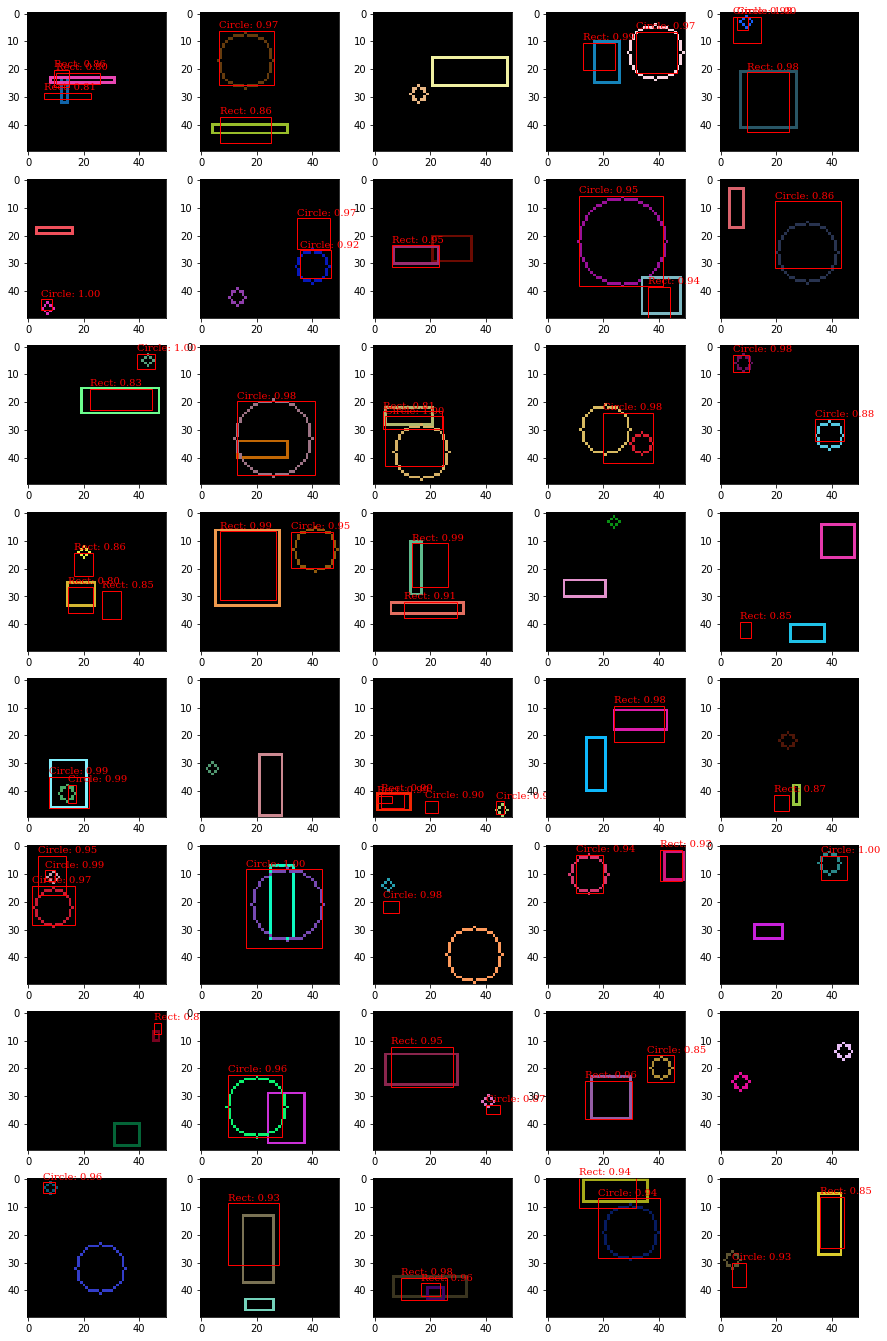

In [25]:
# Prediction with Non-Max supression.
n_pred = 40
idx = np.random.permutation(np.arange(X.shape[0]))[:n_pred]
X_test = X[idx]
Y_test = Y[idx]
Y_pred = model.predict(X_test)
confidence_scores, boxes, class_probs = format_conversion.convert_yolo_grid_to_boxes(Y_pred[0])
#print(confidence_scores.shape)
#print(boxes.shape)
#print(class_probs)

# For each grid use non-max supression. In each cell find box having max confidence. Then check if any other box of grid has IOU more then 0.5 with
# this box then remove second box.
# For each image find boxes having significant threshold.
conf_threshold = 0.8
iou_threshold = 0.3
imgs_pred = []
boxes_pred = []
classes_pred = []
confidence_scores_list = []
for i in range(Y_pred.shape[0]):
    confidence_scores, boxes, class_probs = format_conversion.convert_yolo_grid_to_boxes(Y_pred[i])    
    # Find cells where object presence threshold is more than conf_threshold.
    indicies = np.argwhere(confidence_scores>=conf_threshold)
    indicies = indicies.reshape(np.product(indicies.shape))
    confidence_scores = confidence_scores[indicies]
    boxes = boxes[indicies]
    class_probs = class_probs[indicies]
    # Use non-max supression.
    confidence_scores, boxes, class_probs = non_max_supression(confidence_scores, boxes, class_probs, iou_threshold=iou_threshold)
    # Add data to output.
    imgs_pred.append(X_test[i])
    boxes_pred.append(boxes)
    classes_pred.append(np.argmax(class_probs, axis=1))
    confidence_scores_list.append(confidence_scores)

# Plot predictions.
#print(np.array(imgs_pred), np.array(boxes_pred), np.array(classes_pred), np.array(confidence_scores_list), sep="\n\n")
print("With Non-Max Supression.")
plot_util.plot_img_boxes(imgs_pred,boxes_pred,classes_pred, confidence_scores = confidence_scores_list, cell_width=3,cell_height=3)

In [ ]:
# Prediction.
n_pred = 2
idx = np.random.permutation(np.arange(X.shape[0]))[:n_pred]
X_test = X[idx]
Y_test = Y[idx]
Y_pred = model.predict(X_test)

# Convert predictions to plotable format.
Y_pred_converted = [format_conversion.convert_yolo_grid_to_boxes(Y_pred[i]) for i in range(Y_pred.shape[0])]

# For each image find boxes having significant threshold.
conf_threshold = 0.7
imgs_pred = []
boxes_pred = []
classes_pred = []
confidence_scores_list = []
for i in range(Y_pred.shape[0]):
    confidence_scores, boxes, class_probs = format_conversion.convert_yolo_grid_to_boxes(Y_pred[i])
    # Find cells where object presence threshold is more than conf_threshold.
    indicies = np.argwhere(confidence_scores>=conf_threshold)
    indicies = indicies.reshape(np.product(indicies.shape))
    #print("Num valid boxes:",len(indicies))
    # For current image find boxes and classes at these indicies as these boxes have significant confidence scores.
    boxes_cur = Y_pred_converted[i][1][indicies]
    boxes_pred.append(boxes_cur)
    class_labels = np.argmax(Y_pred_converted[i][2], axis=1)
    class_labels = class_labels[indicies]
    classes_pred.append(class_labels)
    imgs_pred.append(X_test[i])
    conf_scores = confidence_scores[indicies]
    confidence_scores_list.append(conf_scores)

# Plot predictions.
print("Without Non-Max Supression.")
plot_util.plot_img_boxes(imgs_pred,boxes_pred,classes_pred, confidence_scores = confidence_scores_list, cell_width=3,cell_height=3)

In [ ]:
"{:.2f}".format(0.4856)